# MNIST dataset

In [1]:
#import necessary libraries
import numpy as np 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt

#load in data and use data_loader to read it
transform=transforms.ToTensor()#transform images to a torch tensor
train_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)#train=true for train dataset
test_dataset  = datasets.MNIST(root='./data',train=False,download=True,transform=transform)#train=false for test dataset

#use loader to get batches of data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256,shuffle=True)#we want to shuffle testing data

In [2]:
class Model(nn.Module):
    def __init__(self, latent_dims):
        super(Model,self).__init__()
        
        self.DKL=0#starking value for DKL:=DKL(qϕ(z|x)||p(z))

        self.lin1 = nn.Linear(3*3*32, 128)
        self.lin2 = nn.Linear(128, latent_dims)
        self.lin3 = nn.Linear(128, latent_dims)
        
        #encoder, bring from high dimension to low dimension
        self.encoder=nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten()
        )
        
        #decoder, try to recreate the image using only a few features
        self.decoder= nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #encode
        x = self.encoder(x)#first use convolution nn
        x = F.relu(self.lin1(x))
        
        #calculations
        µ =  self.lin2(x)#mean value
        Σ = torch.exp(self.lin3(x))#variance
        z = µ + Σ*torch.distributions.Normal(0, 1).sample(µ.shape)# sample so that z has the shape of µ, mean=µ, and variance=Σ
        self.DKL = (Σ**2 + µ**2 - torch.log(Σ) - 1/2).sum()#DKL(N (µ, Σ)||N (0, I))
        
        #decode
        x=self.decoder(z)# pass in the latent variable z through the decoder network gθ(z) parameterized by θ
        return x

In [3]:
model = Model(latent_dims=4)#define model, 4latent_dims
optim = torch.optim.Adam(model.parameters())#choose optimizer as adam

In [4]:
def Epoch_step(model,dataloader):
    model.train()# Set train mode for both the encoder and the decoder
    Epoch_loss=0.0#start with 0 loss then add on loss after we calculate x_hat
    for x, _ in dataloader: #iterate through databatch images
        x_hat = model(x)#encode then decode x

        LOSS=((x-x_hat)**2).sum()+model.DKL#ℓ(x, xˆ) = ∥xˆ − x∥2 + DKL(N (µ, Σ)||N (0, I))
        optim.zero_grad()# Zero the gradients before running the backward pass.
        LOSS.backward()#backward pass
        optim.step()#optimize parameters
        Epoch_loss+=LOSS.item()#add the ELBO to the loss for each image
    return Epoch_loss/len(dataloader.dataset)#divide loss by number of image to get average

Epoch: 0
loss: 98.88429784342448


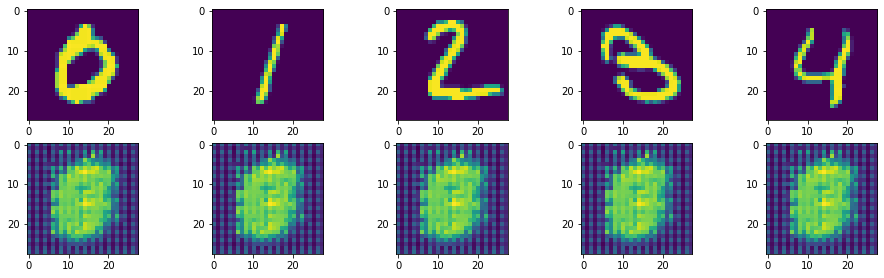

Epoch: 1
loss: 59.50907380371094


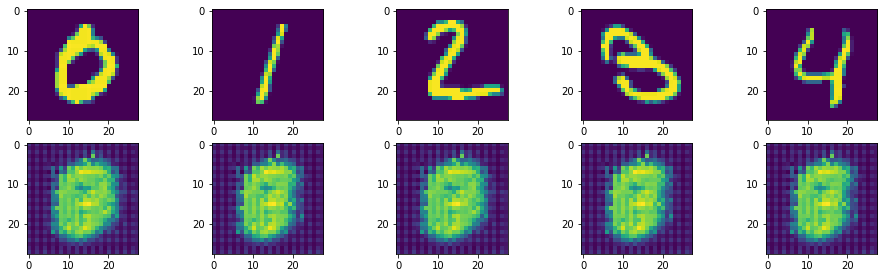

Epoch: 2
loss: 53.33948491210938


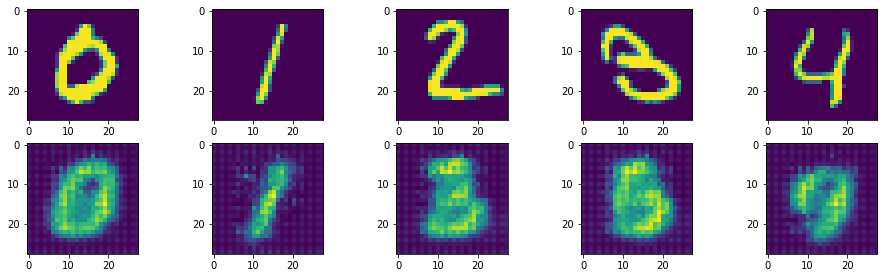

Epoch: 3
loss: 43.377270430501305


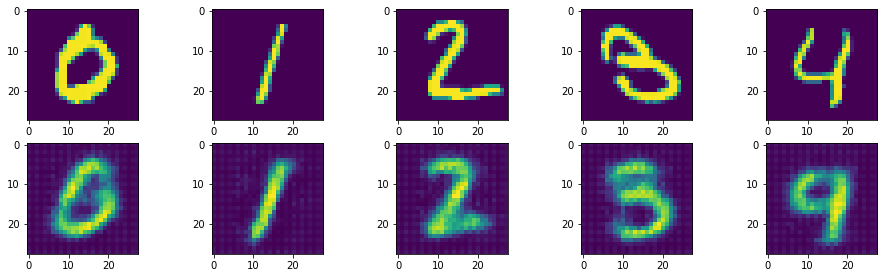

Epoch: 4
loss: 38.58631276041667


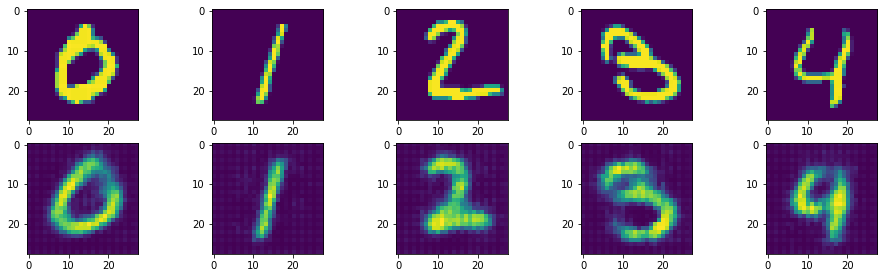

In [5]:
for epoch in range(5):# 5 epochs
    Epoch_loss = Epoch_step(model,train_loader)# run one epoch and return train loss
    print("Epoch:",epoch)#print what epoch we are on
    print("loss:",Epoch_loss)#print loss for each epoch
    #print images
    plt.figure(figsize=(16,4.5))# create fig for images
    target=test_dataset.targets.numpy()#the traget images that we want to work with
    target_idx={i:np.where(target==i)[0][0] for i in range(5)}#find the index of the traget and store it as a list
    for i in range(5):# do this for 5 images
        #plot orriginal image
        ax=plt.subplot(2,5,i+1)#create subplot for new images to be ploted into
        img=test_dataset[target_idx[i]][0].unsqueeze(0)#find image using target index
        plt.imshow(img.squeeze().numpy())#convert image to right dimensions, then convert it to numpy array, then plot

        #create new images
        model.eval()
        with torch.no_grad():#disable gradient caluclation when creating new image
            new_img=model.forward(img)#encode then decode img
        ax=plt.subplot(2, 5, i + 1 + 5)#create subplot for new images to be ploted into
        plt.imshow(new_img.squeeze().numpy())#convert image to right dimensions, then convert it to numpy array, then plot 
    plt.show()#plot the old and new images

### We see that with each epoch the loss goes down and the newly generated images(second row) get better at recreacting the image above them. While we won't get a loss of 0, we can approach it while having all of the benefits of being able to encode our data.